

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



# Installing dependencies and preparing runtime

In [1]:
!pip install -U torch torchvision

In [2]:
!pip install torchinfo

In [3]:
import torch

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
import pickle
import random
import numpy as np
from skimage import io

from tqdm.notebook import tqdm, trange
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import pandas as pd

from torchinfo import summary

In [5]:
!nvidia-smi

Wed Nov 24 22:44:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp /content/drive/MyDrive/journey-springfield.zip /content

In [8]:
!unzip -qq journey-springfield.zip

# Setting random seeds for reproducibility

In [9]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)
# not enabling deterministic mode since this breaks half of pytorch.

# Preparing datasets

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [10]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [11]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transforms):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        # аугментации датасета
        self.transforms = transforms

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        x = self.transforms(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        #return np.array(image)
        return image

In [12]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [13]:
baseline_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

In [14]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [15]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [16]:
val_dataset = SimpsonsDataset(val_files, mode='val', transforms=baseline_transforms)

Давайте посмотрим на наших героев внутри датасета.

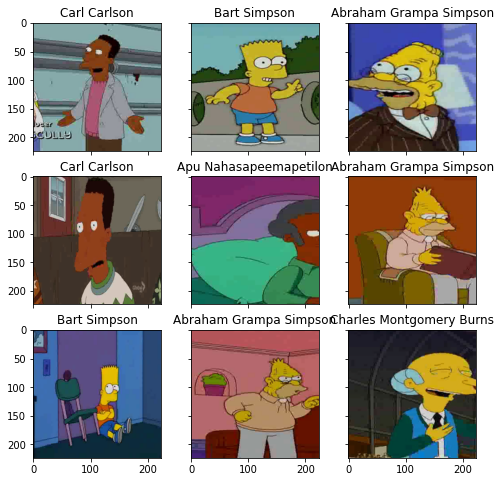

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

*Я не смотрел.*

# Baseline CNN

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [18]:
class SimpleCnn(nn.Module):  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

### Fit/predict functions

In [19]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    inferred = []
    actual = []
    running_loss = 0.0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        inferred.extend(preds.cpu())
        actual.extend(labels.cpu())
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

        # clearing VRAM
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        del inputs
        del labels
        torch.cuda.empty_cache()
    train_loss = running_loss / processed_data
    return train_loss, f1_score(actual, inferred, average="micro")

In [20]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    inferred = []
    actual = []
    running_loss = 0.0
    processed_data = 0

    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        inferred.extend(preds.cpu())
        actual.extend(labels.cpu())
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

        # clearing VRAM
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        del inputs
        del labels
        torch.cuda.empty_cache()
    val_loss = running_loss / processed_data
    return val_loss, f1_score(actual, inferred, average="micro")

In [21]:
def train(train_files, val_files, model, epochs, batch_size, optimizer, optimizer_kwargs={}):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_f1 {t_f1:0.4f} val_f1 {v_f1:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer(model.parameters(), **optimizer_kwargs)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_f1 = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_f1, val_loss, val_f1))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_f1=train_f1, v_f1=val_f1))
            
    return history

In [22]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            inputs = inputs.to("cpu")
            del inputs
            torch.cuda.empty_cache()
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Initialize Baseline CNN

In [23]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("We will classify for {} classes".format(n_classes))
print(simple_cnn)

We will classify for 42 classes
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=24

In [24]:
summary(simple_cnn)

Layer (type:depth-idx)                   Param #
SimpleCnn                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       224
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       1,168
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-7                       4,640
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-10                      18,496
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
├─Sequential: 1-5                        --
│    └─Conv2d: 2-13                      55,392
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
├─Linear: 1-

In [25]:
!nvidia-smi

Wed Nov 24 22:45:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    56W / 149W |    517MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train Baseline CNN

Запустим обучение сети.

In [26]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val', transforms=baseline_transforms)
    
train_dataset = SimpsonsDataset(train_files, mode='train', transforms=baseline_transforms)

In [27]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64, optimizer=torch.optim.Adam)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

loss 2.5315817018262643


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 2.5316     val_loss 1.8614 train_f1 0.2958 val_f1 0.4899


  0%|          | 0/246 [00:00<?, ?it/s]

loss 1.4966698531793465


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 1.4967     val_loss 1.2406 train_f1 0.5884 val_f1 0.6683


In [28]:
!nvidia-smi

Wed Nov 24 22:52:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    60W / 149W |    554MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Построим кривые обучения

In [29]:
def plot_loss(history):
  loss, _, val_loss, _ = zip(*history)
  plt.figure(figsize=(15, 9))
  plt.plot(loss, label="train_loss")
  plt.plot(val_loss, label="val_loss")
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

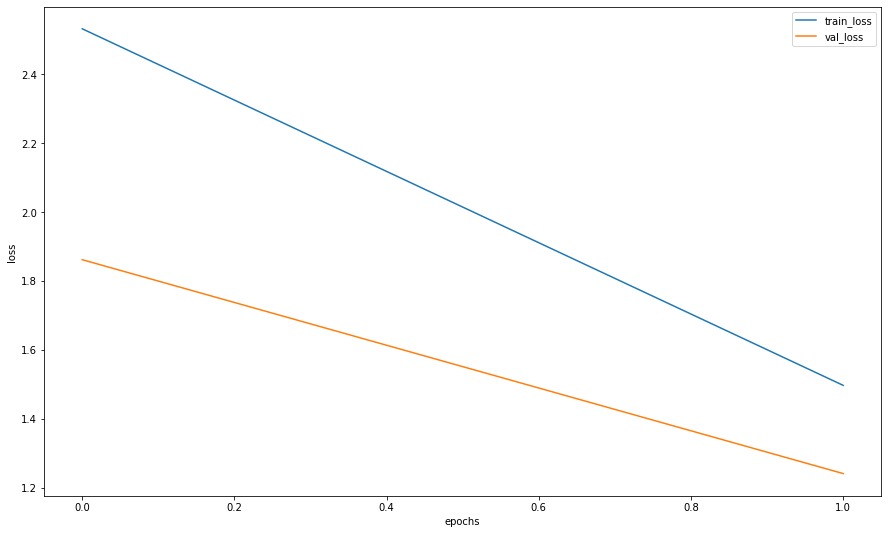

In [30]:
plot_loss(history)

# Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [31]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
        inputs = inputs.to("cpu")
        del inputs
        torch.cuda.empty_cache()
    return probs

In [32]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [33]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [34]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [35]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [36]:
f1_score(actual_labels, y_pred, average="micro")

0.8000000000000002

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

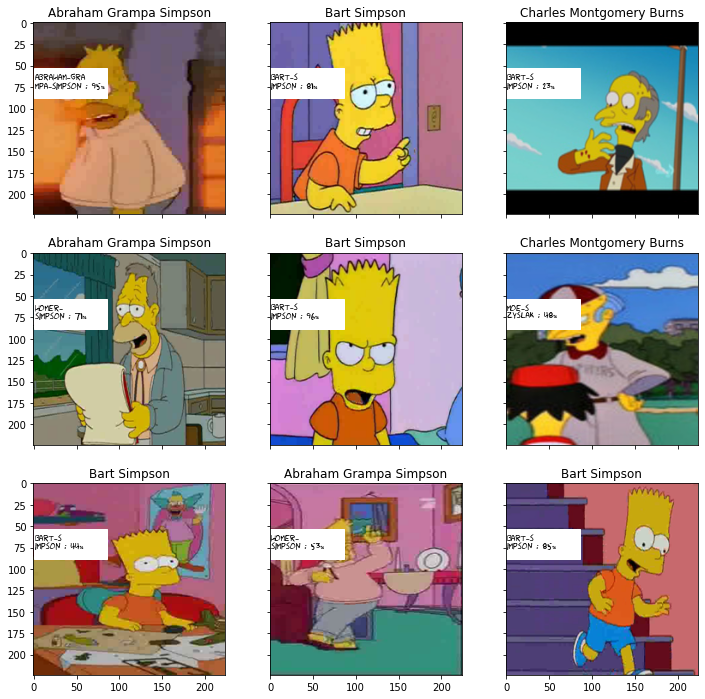

In [37]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

## Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [38]:
test_dataset = SimpsonsDataset(test_files, mode="test", transforms=baseline_transforms)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [39]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [40]:
my_submit.to_csv('drive/MyDrive/simple_cnn_baseline.csv', index=False)

In [41]:
# let's unload (and delete) the model and clear VRAM
simple_cnn = simple_cnn.to("cpu")
del simple_cnn
torch.cuda.empty_cache()

# Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочных улучшений для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!


# Improving upon Baseline CNN

## Adding data augmentation

In [58]:
train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(244),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=30),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(244),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

In [59]:
train_dataset = SimpsonsDataset(train_files, mode='train', transforms=val_transforms)
val_dataset = SimpsonsDataset(val_files, mode='val', transforms=train_transforms)

## Restructure model

In [60]:
class ConvBlock(nn.Module):
  def __init__(self, input, output, conv_size, pool_size):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=input, out_channels=output, kernel_size=conv_size)
    self.activation = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=pool_size)

  def forward(self, x):
    x = self.pool(self.activation(self.conv(x)))
    return x

In [73]:
class ClassifierBlock(nn.Module):
  def __init__(self, input, output, dropout_rate):
    super().__init__()
    self.activation = nn.ReLU()
    self.fc1 = nn.Linear(input, 96 * 5)
    self.fc2 = nn.Linear(96 * 5, 96)
    self.out = nn.Linear(96, output)
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, x):
    x = self.activation(self.fc1(x))
    x = self.dropout(x)
    x = self.activation(self.fc2(x))
    x = self.dropout(x)
    x = self.out(x)
    return x

In [74]:
class RefinedCnn(nn.Module):  
    def __init__(self, n_classes):
      super().__init__()
      self.conv_block1 = ConvBlock(input=3, output=8, conv_size=3, pool_size=2)
      self.batchnorm1 = nn.BatchNorm2d(6)
      self.conv_block2 = ConvBlock(input=8, output=16, conv_size=3, pool_size=2)
      self.batchnorm2 = nn.BatchNorm2d(16)
      self.conv_block3 = ConvBlock(input=16, output=32, conv_size=3, pool_size=2)
      self.batchnorm3 = nn.BatchNorm2d(32)
      self.conv_block4 = ConvBlock(input=32, output=64, conv_size=3, pool_size=2)
      self.batchnorm4 = nn.BatchNorm2d(64)
      self.conv_block5 = ConvBlock(input=64, output=96, conv_size=3, pool_size=2)
      self.batchnorm1 = nn.BatchNorm2d(96)
      self.classifier = ClassifierBlock(96 * 5 * 5, n_classes, dropout_rate=0.5)
  
  
    def forward(self, x):
      x = self.conv_block1(x)
      x = self.conv_block2(x)
      x = self.conv_block3(x)
      x = self.conv_block4(x)
      x = self.conv_block5(x)
      x = x.view(x.size(0), -1)
      logits = self.classifier(x)
      return logits

## Initialize Refined CNN

In [75]:
n_classes = len(np.unique(train_val_labels))
refined_cnn = RefinedCnn(n_classes).to(DEVICE)
print("We will classify for {} classes".format(n_classes))
print(refined_cnn)

We will classify for 42 classes
RefinedCnn(
  (conv_block1): ConvBlock(
    (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (activation): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batchnorm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_block2): ConvBlock(
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (activation): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_block3): ConvBlock(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (activation): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_block4): ConvBlock(
    (conv): Conv2d(32, 64

In [76]:
summary(refined_cnn)

Layer (type:depth-idx)                   Param #
RefinedCnn                               --
├─ConvBlock: 1-1                         --
│    └─Conv2d: 2-1                       224
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─BatchNorm2d: 1-2                       192
├─ConvBlock: 1-3                         --
│    └─Conv2d: 2-4                       1,168
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─BatchNorm2d: 1-4                       32
├─ConvBlock: 1-5                         --
│    └─Conv2d: 2-7                       4,640
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
├─BatchNorm2d: 1-6                       64
├─ConvBlock: 1-7                         --
│    └─Conv2d: 2-10                      18,496
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
├─BatchNorm2d: 1-8                       128
├─ConvBlock: 1

## Train Refined CNN

In [77]:
!nvidia-smi

Wed Nov 24 23:42:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    59W / 149W |   2352MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [78]:
history = train(train_dataset, val_dataset, model=refined_cnn, epochs=5, batch_size=64, optimizer=torch.optim.AdamW, optimizer_kwargs={"lr": 1e-2})

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

loss 3.1627648841864713


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 3.1628     val_loss 3.1135 train_f1 0.1001 val_f1 0.1074


  0%|          | 0/246 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

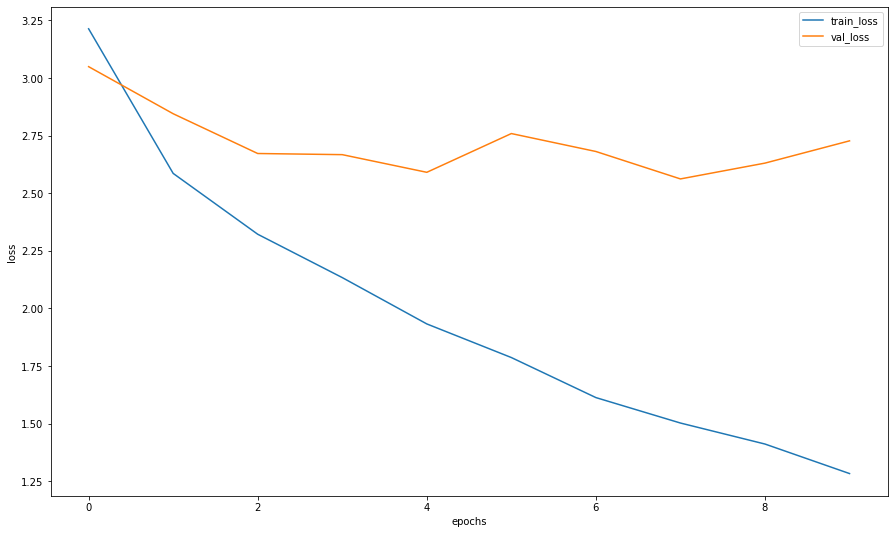

In [51]:
plot_loss(history)

## Test model


The network seems to be even less viable than the baseline model, but whatever, let's try it out.

In [54]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(refined_cnn, imgs)

In [55]:
y_pred = np.argmax(probs_ims,-1)

In [57]:
actual_labels = [val_dataset[id][1] for id in idxs]
f1_score(actual_labels, y_pred, average="micro")

0.35

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test", transforms=baseline_transforms)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()